In [93]:
#submit1. score:0.20629 crossvalidation: 0.20592940285767342
#submit2. score:0.18104 crossvalidation: 0.1822781167369381
#submit3. score:0.16517 crossvalidation: 0.16455070183341483
#submit4. score:0.18170 crossvalidation: 0.18388329418394642

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [55]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
train.head()

In [117]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (22,8)

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

**Чистим от столбцов, в которых есть пропуски в данных**

In [57]:
cols_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt']
train_clear = train.drop(cols_to_drop, axis=1)


**Находим столбцы, в которых малоинформативные признаки и избавляемся от них**

In [58]:
num_rows = len(train_clear.index)
low_information_cols = [] #

for col in train_clear.columns:
    cnts = train_clear[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Street: 99.58904%
Pave    1454
Grvl       6
Name: Street, dtype: int64

Utilities: 99.93151%
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Condition2: 98.97260%
Norm      1445
Feedr        6
PosN         2
Artery       2
RRNn         2
RRAe         1
RRAn         1
PosA         1
Name: Condition2, dtype: int64

RoofMatl: 98.21918%
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
Metal         1
Membran       1
ClyTile       1
Name: RoofMatl, dtype: int64

Heating: 97.80822%
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

LowQualFinSF: 98.21918%
0      1434
80        3
360       2
528       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
371       1
572       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
513       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64

KitchenAbvGr: 95

In [59]:
train_fin = train_clear.drop(low_information_cols, axis=1)

**Находим столбцы с числовыми значениями.** С категориальными особо сегодня не хочу работать :(

In [60]:
train_numeric = train_fin.select_dtypes(include=[np.number])
numeric_cols = train_numeric.columns.values
print(numeric_cols)

['Id' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'TotRmsAbvGrd' 'Fireplaces'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 'ScreenPorch' 'MoSold' 'YrSold' 'SalePrice']


In [61]:
pd.options.display.max_columns = 200
train_numeric.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,1710,1,0,2,1,3,8,0,2,548,0,61,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,1262,0,1,2,0,3,6,1,2,460,298,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,486,0,434,920,920,866,1786,1,0,2,1,3,6,1,2,608,0,42,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,216,0,540,756,961,756,1717,1,0,1,0,3,7,1,3,642,0,35,272,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,2198,1,0,2,1,4,9,1,3,836,192,84,0,0,12,2008,250000


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


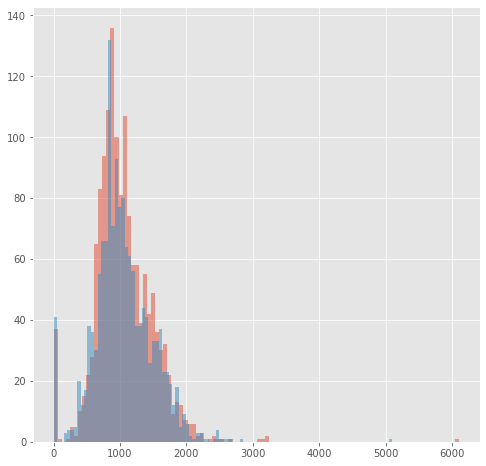

In [198]:
plt.figure(figsize = (8,8))
plt.hist(train['TotalBsmtSF'], bins = 100, label = 'train', alpha = 0.5)
plt.hist(test['TotalBsmtSF'], bins = 100, label = 'test', alpha = 0.5)
plt.show()

***Делаем логарифмы величин***

In [220]:
train['LotAreaLog'] = np.log1p(train['LotArea'])
test['LotAreaLog'] = np.log1p(test['LotArea'])
train['SalePriceLog'] = np.log1p(train['SalePrice'])
# GrLivArea
train['GrLivAreaLog'] = np.log1p(train['GrLivArea'])
test['GrLivAreaLog'] = np.log1p(test['GrLivArea'])
# 1stFlrSF
train['1stFlrSFLog'] = np.log1p(train['1stFlrSF'])
test['1stFlrSFLog'] = np.log1p(test['1stFlrSF'])
# TotRmsAbvGrd показывает странное поведение при логарифмировании
train['TotRmsAbvGrdLog'] = np.log1p(train['TotRmsAbvGrd'])
test['TotRmsAbvGrdLog'] = np.log1p(test['TotRmsAbvGrd'])


In [87]:
train['GrLivAreaLog'].corr(train['1stFlrSFLog'])

0.5459897453392946

In [ ]:
plt.figure(figsize = (8,8))
plt.hist(train['LotAreaLog'], bins = 100, label = 'train', alpha = 0.5)
plt.hist(test['LotAreaLog'], bins = 100, label = 'test', alpha = 0.5)
plt.show()

In [ ]:
plt.figure(figsize = (8,8))
plt.hist(train['SalePriceLog'], bins = 100, label = 'train', alpha = 0.5)
plt.show()

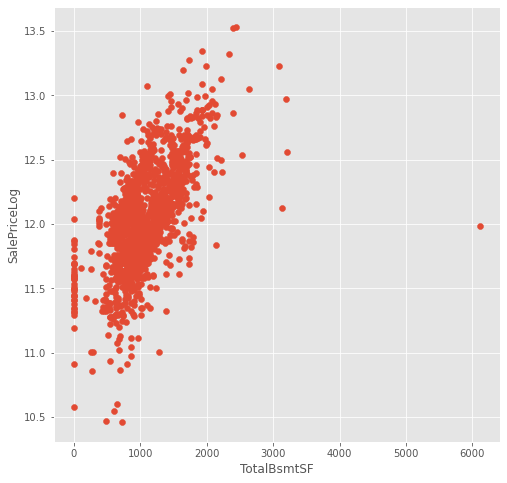

In [199]:
plt.figure(figsize= (8,8))
plt.scatter( train['TotalBsmtSF'], train['SalePriceLog'])
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePriceLog')
plt.show()

# **Кроссвалидация тут**

In [ ]:
kf = KFold(n_splits = 5)
kf.get_n_splits(train)

In [249]:
# features1 = ['LotAreaLog', 'OverallQual', 'GrLivAreaLog', '1stFlrSFLog', 'YearBuiltNorm', 'GarageAreaNorm']
features1 = ['LotAreaLog', 'OverallQual', 'GrLivAreaLog', '1stFlrSFLog', 'YearBuiltNorm', 'TotRmsAbvGrd']
features2 = ['TotalBsmtSF' ]

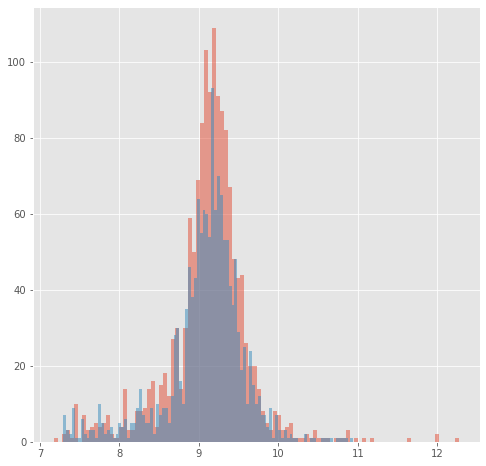

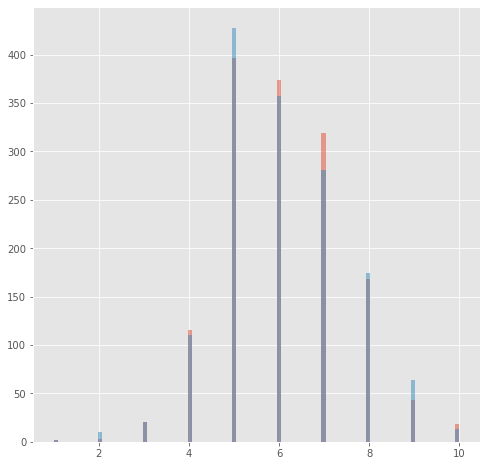

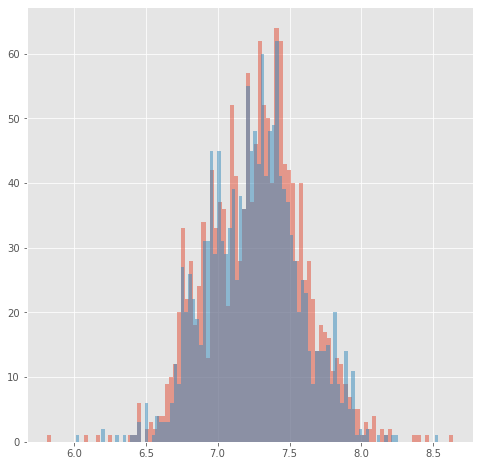

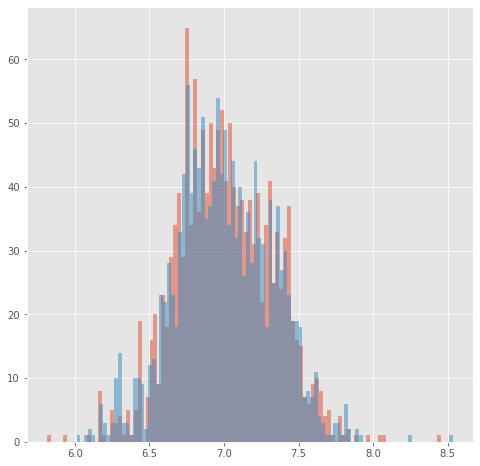

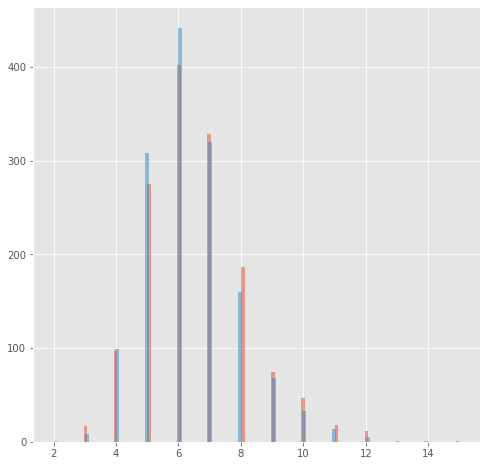

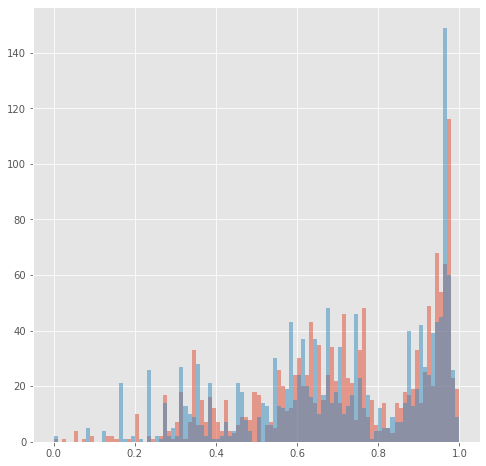

In [177]:
for f in features1:
    plt.figure(figsize = (8,8))
    plt.hist(train[f], bins = 100, label = 'train', alpha = 0.5)
    plt.hist(test[f], bins = 100, label = 'test', alpha = 0.5)
    plt.show()

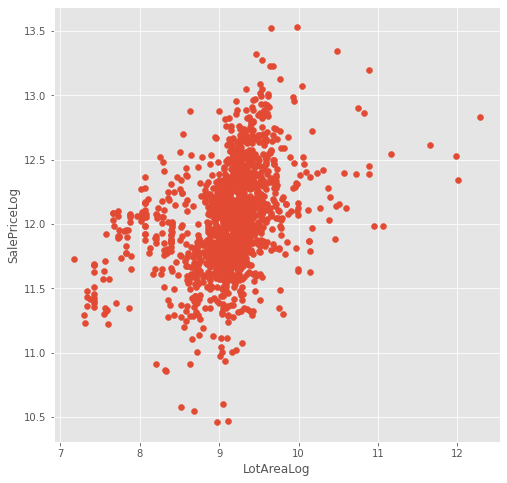

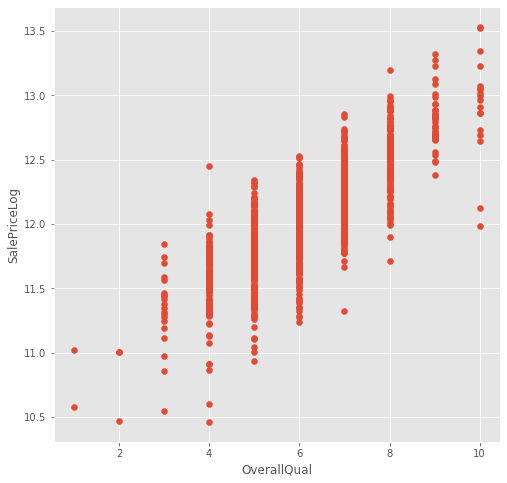

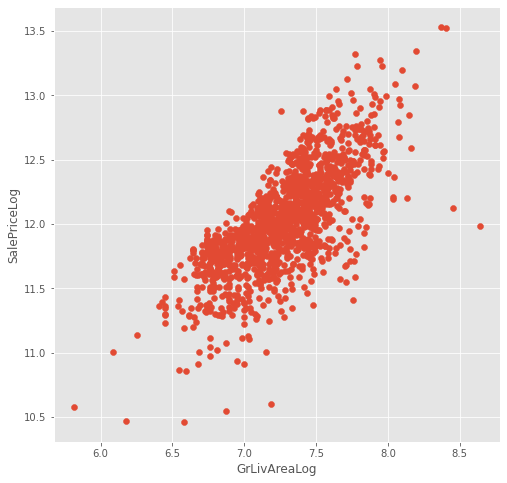

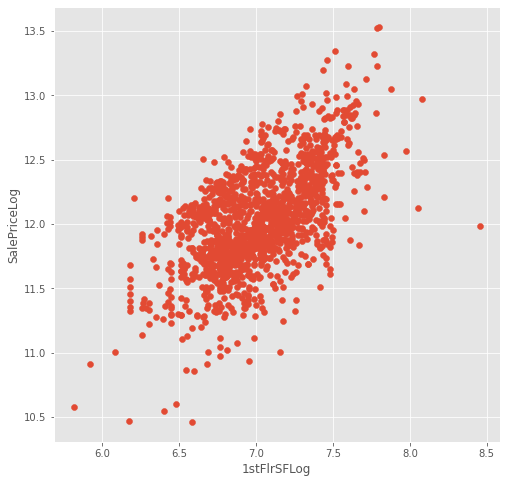

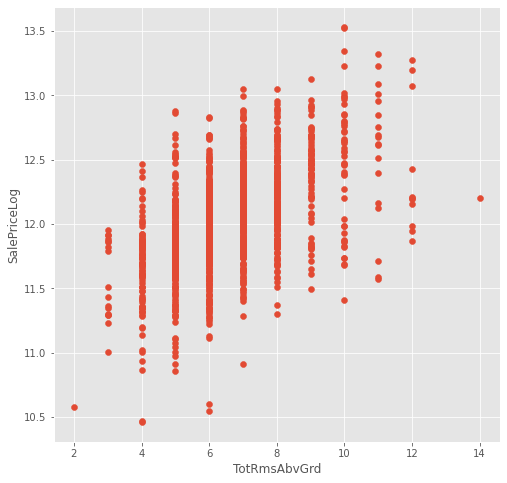

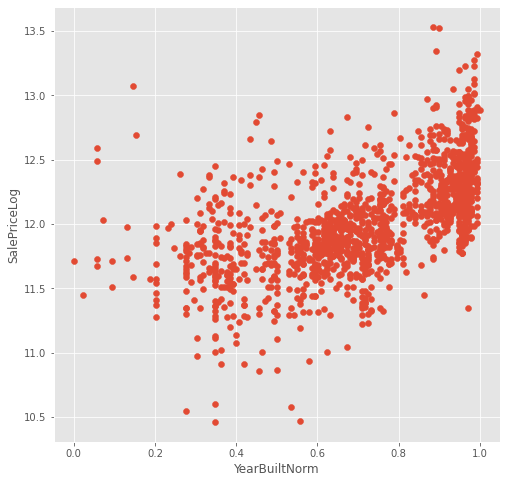

In [178]:
for f in features1:
    plt.figure(figsize= (8,8))
    plt.scatter(train[f], train['SalePriceLog'])
    plt.xlabel(f)
    plt.ylabel('SalePriceLog')
    plt.show()

In [145]:
_min = min(train['LotAreaLog'])
_max = max(train['LotAreaLog'])
train['LotAreaLogNorm'] = (train['LotAreaLog'] - _min)/(_max - _min)
_min = min(train['OverallQual'])
_max = max(train['OverallQual'])
train['OverallQualNorm'] = (train['OverallQual'] - _min)/(_max - _min)
_min = min(train['GrLivAreaLog'])
_max = max(train['GrLivAreaLog'])
train['GrLivAreaLogNorm'] = (train['GrLivAreaLog'] - _min)/(_max - _min)
_min = min(train['1stFlrSFLog'])
_max = max(train['1stFlrSFLog'])
train['1stFlrSFLogNorm'] = (train['1stFlrSFLog'] - _min)/(_max - _min)
_min = min(train['TotRmsAbvGrd'])
_max = max(train['TotRmsAbvGrd'])
train['TotRmsAbvGrdNorm'] = (train['TotRmsAbvGrd'] - _min)/(_max - _min)

features1norm = ['LotAreaLogNorm', 'OverallQualNorm', 'GrLivAreaLogNorm', '1stFlrSFLogNorm', 'TotRmsAbvGrdNorm']

In [174]:
# YearBuilt
_min = min(train['YearBuilt'])
_max = max(train['YearBuilt'])
train['YearBuiltNorm'] = (train['YearBuilt'] - _min)/(_max - _min)
_min = min(test['YearBuilt'])
_max = max(test['YearBuilt'])
test['YearBuiltNorm'] = (test['YearBuilt'] - _min)/(_max - _min)

In [240]:
# GarageArea
_min = min(train['GarageArea'])
_max = max(train['GarageArea'])
train['GarageAreaNorm'] = (train['GarageArea'] - _min)/(_max - _min)
_min = min(test['GarageArea'])
_max = max(test['GarageArea'])
test['GarageAreaNorm'] = (test['GarageArea'] - _min)/(_max - _min)

In [251]:
print(kf)
reg_model = LinearRegression()
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, features1 ], train.loc[test_index, features1]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']

    reg_model.fit(X_train, y_train)
    predict = reg_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=5, random_state=None, shuffle=False)
0 0.15119921192455982
1 0.17096497391786947
2 0.166489526137408
3 0.15231231174923984
4 0.18178748543799658
Mean rmse for 5-fold: 0.16455070183341475
std rmse for 5-fold: 0.011576261138424936


1 аргумент:
* Mean rmse for 5-fold: 0.36610553458247586
* std rmse for 5-fold: 0.014223113160126786

2 аргумента:
* Mean rmse for 5-fold: 0.20592940285767342
* std rmse for 5-fold: 0.009261118671450628

![](http://)3 аргумента: 
* Mean rmse for 5-fold: 0.18819389122943653
* std rmse for 5-fold: 0.008821647379472804

4 аргумента:
* Mean rmse for 5-fold: 0.1822781167369381
* std rmse for 5-fold: 0.009271730315584328

5 аргументов:
* Mean rmse for 5-fold: 0.16455070183341483
* std rmse for 5-fold: 0.011576261138424908

# SGDRegressor

In [208]:
print(kf)
sgd_model = SGDRegressor(max_iter = 1000000)
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, features1 ], train.loc[test_index, features1]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']

    sgd_model.fit(X_train, y_train)
    predict = sgd_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse, 'coef', sgd_model.coef_)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=5, random_state=None, shuffle=False)
0 0.2168621397191122 coef [ 0.20717372  0.08309841  0.93810986  0.4501707  -0.11193398  0.27529477
 -0.07456415]
1 0.2424333310305157 coef [ 0.21020438  0.090514    0.89323249  0.48158547 -0.10227023  0.24330642
 -0.07136578]
2 0.22743268115851736 coef [ 0.21542842  0.09513708  0.86456751  0.49528885 -0.09830474  0.24162228
 -0.0519304 ]
3 0.2221415857981555 coef [ 0.20760084  0.08281504  0.85996847  0.51572612 -0.0958218   0.25225227
 -0.03621508]
4 0.25875022220653926 coef [ 0.21226668  0.08781192  0.86610766  0.50110217 -0.09701924  0.22773958
  0.00514693]
Mean rmse for 5-fold: 0.233523991982568
std rmse for 5-fold: 0.01523167471117646


# SGD+Linear

In [260]:
print(kf)
reg_model = LinearRegression()
sgd_model = SGDRegressor(max_iter = 1000000)
rmse_list = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, features1], train.loc[test_index, features1]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']

    sgd_model.fit(X_train, y_train)
    reg_model.fit(X_train, y_train)
    predict = (sgd_model.predict(X_test) + reg_model.predict(X_test))/2
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse, 'coef', sgd_model.coef_)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=5, random_state=None, shuffle=False)
0 0.16897545707348618 coef [ 0.19371646  0.08497457  0.92551842  0.47334576  0.23006535 -0.11064489]
1 0.19101013785840512 coef [ 0.20751142  0.08317551  0.90158985  0.47357626  0.24614103 -0.10141292]
2 0.20717085191813672 coef [ 0.20875516  0.08602438  0.8649901   0.50080736  0.19412439 -0.10798681]
3 0.17678300457559964 coef [ 0.18623493  0.09153277  0.85647947  0.56635886  0.11435564 -0.1033402 ]
4 0.20549108062244398 coef [ 0.1949554   0.08409596  0.91206957  0.48280429  0.25720886 -0.10199798]
Mean rmse for 5-fold: 0.1898861064096143
std rmse for 5-fold: 0.01518214495719501


# **Обучение модели**

In [ ]:
reg_model.coef_

In [257]:
reg_model = LinearRegression()
reg_model.fit(train[features1], train['SalePriceLog'])
reg_model.coef_

sgd_model = SGDRegressor(max_iter = 1000000)
sgd_model.fit(train[features1], train['SalePriceLog'])
sgd_model.coef_

array([ 0.20843314,  0.08457717,  0.92600034,  0.45912761,  0.25020377,
       -0.1039216 ])

In [259]:
prediction = (reg_model.predict(test[features1]) + sgd_model.predict(test[features1]))/2

sample_submission = pd.read_csv ("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
sample_submission['SalePrice'] = np.exp(prediction)

In [176]:
sample_submission.head

<bound method NDFrame.head of         Id      SalePrice
0     1461  118177.357652
1     1462  165689.967244
2     1463  171386.472895
3     1464  183444.724463
4     1465  206077.859225
...    ...            ...
1454  2915   87801.293215
1455  2916   86721.773086
1456  2917  145884.598986
1457  2918  133819.446972
1458  2919  218895.191187

[1459 rows x 2 columns]>

In [ ]:
sample_submission.to_csv('submission5.csv', index = None)

# Итоги

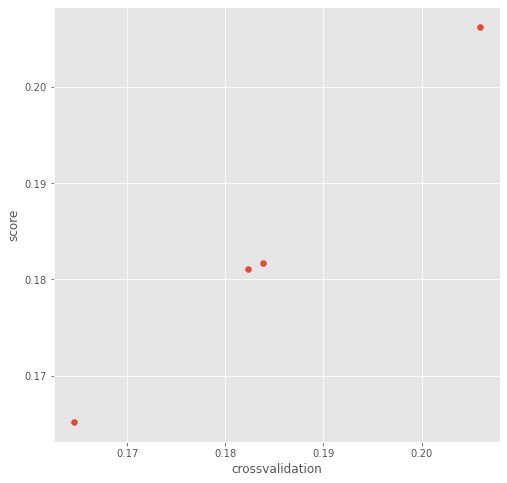

In [261]:
plt.figure(figsize= (8,8))
plt.scatter( [0.20592940285767342, 0.1822781167369381, 0.16455070183341483, 0.18388329418394642], [0.20629, 0.18104, 0.16517, 0.18170])
plt.xlabel('crossvalidation')
plt.ylabel('score')
plt.show()
#submit1. score:0.20629 crossvalidation: 0.20592940285767342
#submit2. score:0.18104 crossvalidation: 0.1822781167369381
#submit3. score:0.16517 crossvalidation: 0.16455070183341483
#submit4. score:0.18170 crossvalidation: 0.18388329418394642